# FINAL PROJECT CODE

### Varak, Adam, Chuning

In [61]:
# Setup

# Libraries
import pandas as pd
import plotly.express as px
import numpy as np
from scipy.stats import spearmanr, f_oneway
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample


# Load the CSV file
file_path = "CSCS_data_anon.csv"  # Update with your file path
df = pd.read_csv(file_path)


C:\Users\eznam\AppData\Local\Temp\ipykernel_2280\497883375.py:18: DtypeWarning:

Columns (408,1001,1002,1006,1007,1008,1080,1113,1115,1116,1117,1118,1119,1120,1121,1124,1125,1126,1127,1128,1213,1214,1215,1216,1217,1218,1342,1343,1344,1345,1346,1347,1348,1349,1390,1391,1393,1463,1549,1552,1555,1558,1561) have mixed types. Specify dtype option on import or set low_memory=False.



#### Question 1: Does the frequency of COVID-19 preventive behaviours (specifically mask-wearing) correlate with **self-rated physical health**?

Variables:
- `COVID_prevention_masks`: Indicates whether individuals are engaging in mask-wearing as a preventive measure (categorical: never, sometimes, often, always)
- `WELLNESS_self_rated_physical_health`: Individual's perception of their physical health (continuous scale: 1-10)

Hypotheses:

- H₀: There is no monotonic relationship between mask-wearing frequency and self-rated physical health (ρ = 0)
- H₁: There exists a positive monotonic relationship between mask-wearing frequency and self-rated physical health (ρ > 0)


In [47]:
# Step 1: Clean up the data

# Copy OG df to work w/ new one
df1 = df[['COVID_prevention_masks', 'WELLNESS_self_rated_physical_health']].copy()

# Replace 'Presented but no response' w/ NaN
df1['COVID_prevention_masks'] = df1['COVID_prevention_masks'].replace('Presented but no response', np.nan)
df1['WELLNESS_self_rated_physical_health'] = df1['WELLNESS_self_rated_physical_health'].replace('Presented but no response', np.nan)

# Replace 'NA' with NaN to handle text-based 'NA' values properly
df1['COVID_prevention_masks'] = df1['COVID_prevention_masks'].replace('NA', np.nan)
df1['WELLNESS_self_rated_physical_health'] = df1['WELLNESS_self_rated_physical_health'].replace('NA', np.nan)

# Drop all rows where either column has NaN (missing values or "Presented but no response" or "NA")
df1 = df1.dropna(subset=['COVID_prevention_masks', 'WELLNESS_self_rated_physical_health'])

# Map values for 'COVID_prevention_masks'
mask_mapping = {
    'Not at all': 1,
    'Somewhat closely': 2,
    'Very closely': 3
}

# Map values for WELLNESS_self_rated_physical_health categories
health_mapping = {
    'Poor': 1,
    'Fair': 2,
    'Good': 3,
    'Very good': 4,
    'Excellent': 5
}

df1['COVID_prevention_masks'] = df1['COVID_prevention_masks'].map(mask_mapping)
df1['WELLNESS_self_rated_physical_health'] = df1['WELLNESS_self_rated_physical_health'].map(health_mapping)

# Ensure rows with NaN values after mapping are also dropped
df1 = df1.dropna(subset=['COVID_prevention_masks', 'WELLNESS_self_rated_physical_health'])

# Optionally, print the number of rows after cleanup to ensure it was done correctly
print(f"Number of rows after cleanup: {df1.shape[0]}")

Number of rows after cleanup: 8204


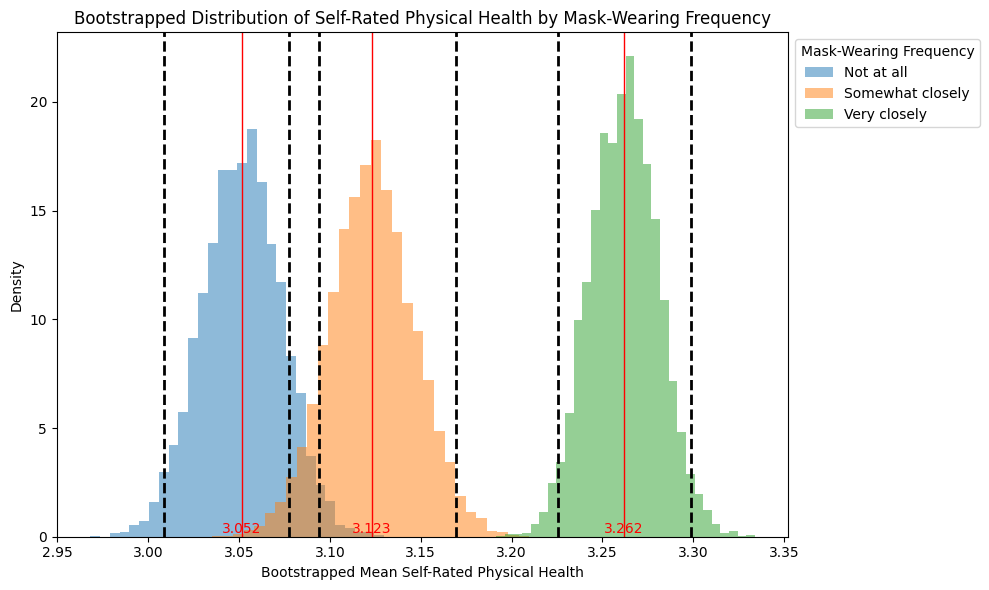

Mask-Wearing Frequency: Somewhat closely
95% Confidence Interval for Mean Self-Rated Physical Health: (3.08, 3.17)

Mask-Wearing Frequency: Not at all
95% Confidence Interval for Mean Self-Rated Physical Health: (3.01, 3.09)

Mask-Wearing Frequency: Very closely
95% Confidence Interval for Mean Self-Rated Physical Health: (3.23, 3.30)

ANOVA result: F-statistic = 29.062, p-value = 0.000
The null hypothesis is rejected: there are significant differences between the groups.
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   0.0717 0.0709 -0.0046 0.1481  False
     1      3   0.2102    0.0  0.1434  0.277   True
     2      3   0.1385    0.0  0.0679  0.209   True
---------------------------------------------------
Spearman's correlation between mask-wearing frequency and self-rated health: 0.937 (p-value: 0.000)


In [53]:
# Bootstrapped Histogram (without density label)
plt.figure(figsize=(10, 6))

# Label map for the mask groups
mask_labels = {
    1: 'Not at all',
    2: 'Somewhat closely',
    3: 'Very closely'
}

# Plot the bootstrap distributions as histograms
for i, mask_value in enumerate([1, 2, 3]):  # Explicitly ensure correct order
    # Get the bootstrap samples for the current mask group
    bootstrap_samples = bootstrap_means[mask_value]
    
    # Plot the histogram for each mask-wearing group
    plt.hist(bootstrap_samples, bins=30, alpha=0.5, label=mask_labels[mask_value], density=True)

    # Add a red line at the mean of the bootstrap samples for each group
    mean_value = np.mean(bootstrap_samples)
    plt.axvline(mean_value, color='red', linestyle='-', lw=1)  # Thinner red line
    
    # Label the red line with the actual average value
    plt.text(mean_value, 0.04, f'{mean_value:.3f}', color='red', ha='center', va='bottom')  # Average Health Score

# Overlay the confidence intervals as vertical lines
for i, mask_value in enumerate([1, 2, 3]):  # Explicitly ensure correct order
    plt.axvline(ci_lower[mask_value], color='black', linestyle='--', lw=2)
    plt.axvline(ci_upper[mask_value], color='black', linestyle='--', lw=2)

# Title and labels
plt.title("Bootstrapped Distribution of Self-Rated Physical Health by Mask-Wearing Frequency")
plt.xlabel("Bootstrapped Mean Self-Rated Physical Health")
plt.ylabel("Density")

# Place legend at the top-left, but away from the y-axis
plt.legend(title='Mask-Wearing Frequency', loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

# Optionally, print the confidence intervals for each group
for mask_value in df1['COVID_prevention_masks'].unique():
    print(f"Mask-Wearing Frequency: {mask_labels[mask_value]}")
    print(f"95% Confidence Interval for Mean Self-Rated Physical Health: ({ci_lower[mask_value]:.2f}, {ci_upper[mask_value]:.2f})\n")

# One-way ANOVA test to check for significant differences
anova_result = f_oneway(
    df1[df1['COVID_prevention_masks'] == 1]['WELLNESS_self_rated_physical_health'],
    df1[df1['COVID_prevention_masks'] == 2]['WELLNESS_self_rated_physical_health'],
    df1[df1['COVID_prevention_masks'] == 3]['WELLNESS_self_rated_physical_health']
)

print(f"ANOVA result: F-statistic = {anova_result.statistic:.3f}, p-value = {anova_result.pvalue:.3f}")

# If p-value < 0.05, reject the null hypothesis that the groups are the same
if anova_result.pvalue < 0.05:
    print("The null hypothesis is rejected: there are significant differences between the groups.")
else:
    print("The null hypothesis is not rejected: no significant differences between the groups.")

# Tukey's HSD test for pairwise comparisons (if ANOVA is significant)
if anova_result.pvalue < 0.05:
    tukey_result = pairwise_tukeyhsd(df1['WELLNESS_self_rated_physical_health'], df1['COVID_prevention_masks'])
    print(tukey_result)

# Spearman's correlation calculation (on all bootstrapped samples)
all_bootstrapped_values = []
all_group_labels = []

# Add bootstrapped values for each mask-wearing group
for mask_value in [1, 2, 3]:
    bootstrap_samples = bootstrap_means[mask_value]
    all_bootstrapped_values.extend(bootstrap_samples)
    all_group_labels.extend([mask_value] * len(bootstrap_samples))

# Now calculate Spearman's correlation on the full dataset
corr, p_value = spearmanr(all_group_labels, all_bootstrapped_values)

print(f"Spearman's correlation between mask-wearing frequency and self-rated health: {corr:.3f} (p-value: {p_value:.3f})")


Spearman's correlation between mask-wearing frequency and self-rated health: 1.000 (p-value: 0.000)


C:\Users\eznam\AppData\Local\Temp\ipykernel_2280\867649328.py:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




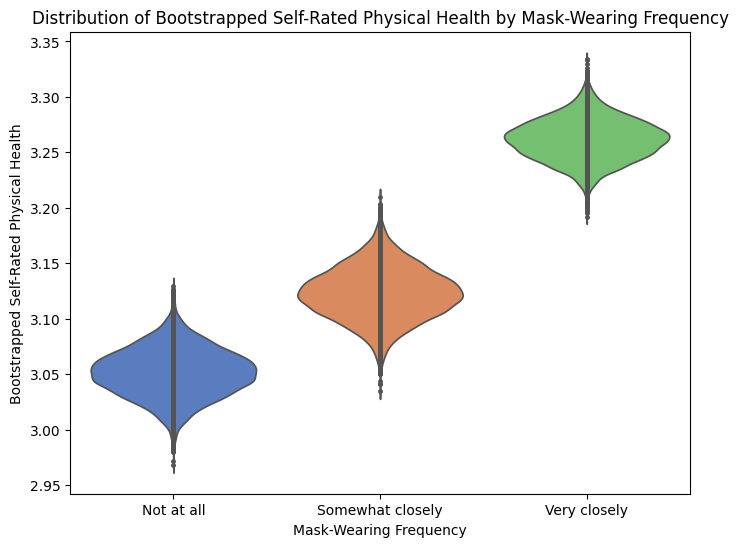

In [54]:
# Now let's calculate the correlation (Spearman's rank)
# Create a list of the means for each group and calculate correlation
mask_means = [np.mean(bootstrap_means[mask_value]) for mask_value in [1, 2, 3]]
mask_labels_ordered = [mask_labels[mask_value] for mask_value in [1, 2, 3]]

# Calculate Spearman's correlation correctly
# Using ordinal 1, 2, 3 as mask-wearing frequency
corr, p_value = spearmanr([1, 2, 3], mask_means)  # Using 1, 2, 3 as ordinal values for mask groups
print(f"Spearman's correlation between mask-wearing frequency and self-rated health: {corr:.3f} (p-value: {p_value:.3f})")

# Prepare data for the violin plot
violin_data = []
mask_labels = []

# Add bootstrapped values for each mask-wearing group
for mask_value in [1, 2, 3]:
    bootstrap_samples = bootstrap_means[mask_value]
    violin_data.extend(bootstrap_samples)
    mask_labels.extend([mask_value] * len(bootstrap_samples))

# Create the violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(x=mask_labels, y=violin_data, inner="point", palette="muted")

# Set axis labels and title
plt.title("Distribution of Bootstrapped Self-Rated Physical Health by Mask-Wearing Frequency")
plt.xlabel("Mask-Wearing Frequency")
plt.ylabel("Bootstrapped Self-Rated Physical Health")
plt.xticks([0, 1, 2], ['Not at all', 'Somewhat closely', 'Very closely'])

# Show the plot
plt.show()


## Question 2: Is there an association between the level of social activity and self-rated mental health among individuals during the COVID-19 pandemic?

Variables:
- SOCIAL_activity_level: Frequency of social interactions (categorical: low, moderate, high)
- WELLNESS_self_rated_mental_health: Self-assessed mental health score (continuous scale: 1-10)

Hypotheses:
- H₀: All group means are equal (μ₁ = μ₂ = μ₃)
- H₁: At least one group mean differs significantly (μᵢ ≠ μⱼ for some i,j)



In [58]:
# Step 1: Clean up the data for Research Question 2

# Create a copy of the original dataframe with only the relevant columns
df2 = df[['CONNECTION_social_num_close_friends', 'WELLNESS_self_rated_mental_health']].copy()

# Replace 'Presented but no response' with NaN
df2['WELLNESS_self_rated_mental_health'] = df2['WELLNESS_self_rated_mental_health'].replace('Presented but no response', np.nan)

# Drop rows where either 'CONNECTION_social_num_close_friends' or 'WELLNESS_self_rated_mental_health' contain NA or 'Presented but no response'
df2 = df2.dropna(subset=['CONNECTION_social_num_close_friends', 'WELLNESS_self_rated_mental_health'])

# Map values for 'WELLNESS_self_rated_mental_health' categories
mental_health_mapping = {
    'Poor': 1,
    'Fair': 2,
    'Good': 3,
    'Very good': 4,
    'Excellent': 5
}
df2['WELLNESS_self_rated_mental_health'] = df2['WELLNESS_self_rated_mental_health'].map(mental_health_mapping)

# Verify the cleanup and print the number of rows remaining
print(f"Number of rows after cleanup: {df2.shape[0]}")


Number of rows after cleanup: 5348


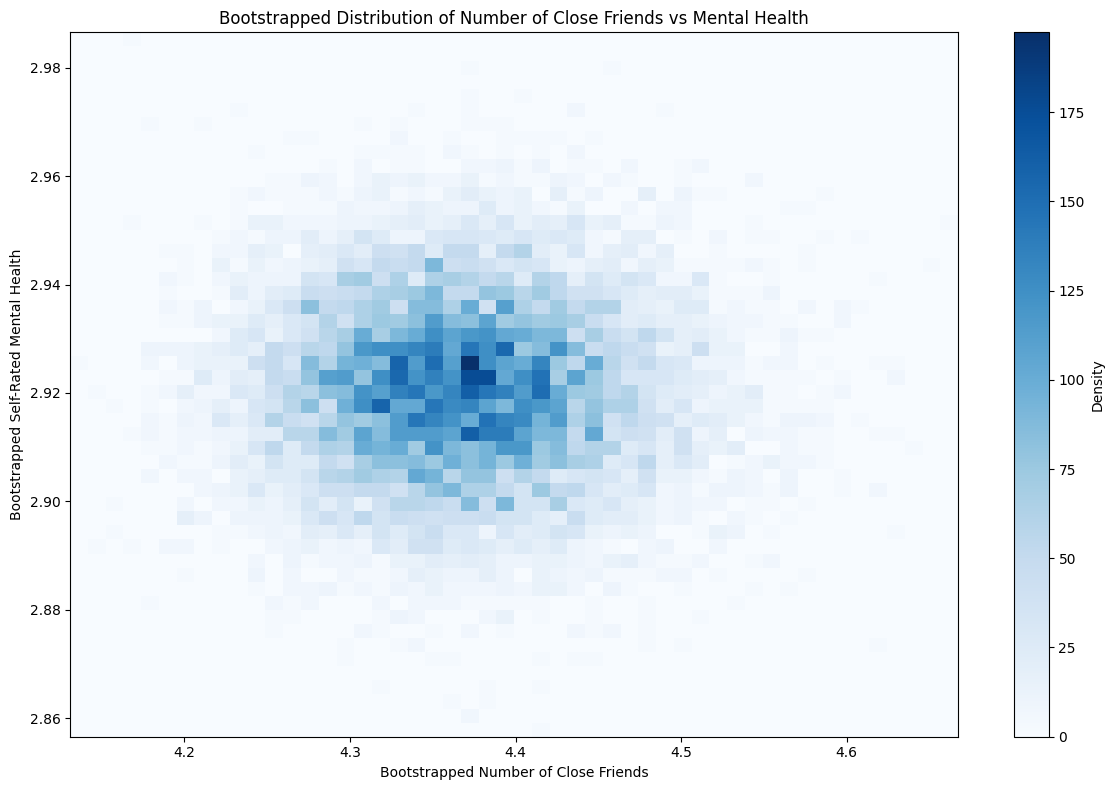

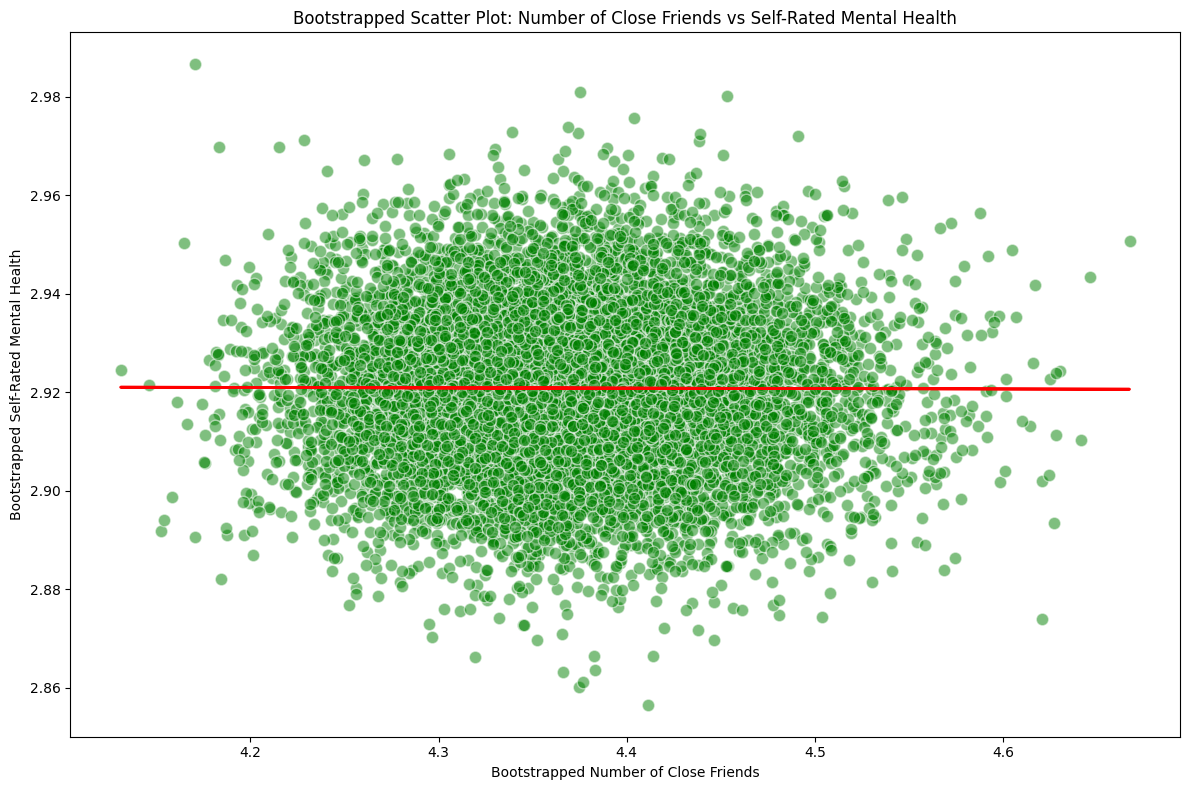

Spearman's correlation between number of close friends and self-rated mental health: -0.004 (p-value: 0.690)
95% Confidence Interval for Number of Close Friends (Lower: 4.24, Upper: 2.89)
95% Confidence Interval for Self-Rated Mental Health (Lower: 4.52, Upper: 2.95)
The null hypothesis is not rejected: no significant correlation between the number of close friends and self-rated mental health.


In [67]:
# Step 3: Updated Graphs for Research Question 2

# Function to generate bootstrap samples and compute means
def bootstrap(data, n_iterations=10000, sample_size=None):
    if sample_size is None:
        sample_size = len(data)
    means = []
    for _ in range(n_iterations):
        # Create a bootstrap sample
        sample = resample(data, n_samples=sample_size)
        means.append(np.mean(sample))
    return np.array(means)

# Bootstrap for 'CONNECTION_social_num_close_friends' and 'WELLNESS_self_rated_mental_health'
bootstrap_friends = bootstrap(df2['CONNECTION_social_num_close_friends'].dropna())
bootstrap_mental_health = bootstrap(df2['WELLNESS_self_rated_mental_health'].dropna())

# 1. Improved 2D Bootstrapped Histogram: Number of Friends vs Mental Health (Plotting Number of Friends on x-axis, Mental Health on y-axis)
plt.figure(figsize=(12, 8))

# Plotting the bootstrapped samples in 2D histogram (using more bins for better resolution)
plt.hist2d(bootstrap_friends, bootstrap_mental_health, bins=[50, 50], cmap='Blues', density=True)

# Adding color bar for density
plt.colorbar(label='Density')

# Adding title and labels
plt.title("Bootstrapped Distribution of Number of Close Friends vs Mental Health")
plt.xlabel("Bootstrapped Number of Close Friends")
plt.ylabel("Bootstrapped Self-Rated Mental Health")

# Display the plot
plt.tight_layout()
plt.show()

# 2. Bootstrapped Scatter Plot with Line of Best Fit
plt.figure(figsize=(12, 8))

# Scatter plot for bootstrapped values of "Number of Friends" vs "Mental Health"
plt.scatter(bootstrap_friends, bootstrap_mental_health, alpha=0.5, color='green', edgecolors='w', s=80)

# Adding a red line for the line of best fit (Linear Regression)
slope, intercept = np.polyfit(bootstrap_friends, bootstrap_mental_health, 1)
plt.plot(bootstrap_friends, slope * bootstrap_friends + intercept, color='red', lw=2, label='Line of Best Fit')

# Adding title and labels
plt.title("Bootstrapped Scatter Plot: Number of Close Friends vs Self-Rated Mental Health")
plt.xlabel("Bootstrapped Number of Close Friends")
plt.ylabel("Bootstrapped Self-Rated Mental Health")

# Display the plot
plt.tight_layout()
plt.show()

# 3. Spearman's correlation calculation on bootstrapped samples
corr, p_value = spearmanr(bootstrap_friends, bootstrap_mental_health)
print(f"Spearman's correlation between number of close friends and self-rated mental health: {corr:.3f} (p-value: {p_value:.3f})")

# 4. Compute confidence intervals for the bootstrapped correlation
ci_lower, ci_upper = np.percentile(bootstrap_friends, [2.5, 97.5]), np.percentile(bootstrap_mental_health, [2.5, 97.5])

print(f"95% Confidence Interval for Number of Close Friends (Lower: {ci_lower[0]:.2f}, Upper: {ci_upper[0]:.2f})")
print(f"95% Confidence Interval for Self-Rated Mental Health (Lower: {ci_lower[1]:.2f}, Upper: {ci_upper[1]:.2f})")

# 5. Hypothesis testing (for correlation)
# Testing the null hypothesis that there is no correlation (rho = 0)
if p_value < 0.05:
    print("The null hypothesis is rejected: there is a significant correlation between the number of close friends and self-rated mental health.")
else:
    print("The null hypothesis is not rejected: no significant correlation between the number of close friends and self-rated mental health.")


#### Question 3: Does the percentage of time spent working remotely influence self-rated productivity?

Variables:
- `Work_hours_per_weel`: Number of hours worked per week
- `WORK_shift_consistent_hours`: Self-assessed productivity level (continuous scale: 1-10)

Hypotheses:
- H₀: No correlation between number of hours worked and consistency of hours worked
- H₁: Negative correlation between consistency and number of hours worked



In [76]:
# Step 1: Clean up the data for Research Question 3

# Create a copy of the original dataframe with only the relevant columns
df3 = df[['WORK_shift_consistent_hours', 'WORK_hours_per_week']].copy()

# Replace 'Presented but no response' and 'NA' or 'na' with NaN in both columns
df3['WORK_shift_consistent_hours'] = df3['WORK_shift_consistent_hours'].replace(
    ['Presented but no response', 'NA', 'na'], np.nan)
df3['WORK_hours_per_week'] = df3['WORK_hours_per_week'].replace(
    ['Presented but no response', 'NA', 'na'], np.nan)

# Map 'WORK_shift_consistent_hours' from categorical to numeric values
consistency_mapping = {
    'Always': 1,
    'Usually': 2,
    'Rarely': 3,
    'Never': 4,
    'Sometimes': 5
}
df3['WORK_shift_consistent_hours'] = df3['WORK_shift_consistent_hours'].map(consistency_mapping)

# Drop rows where both 'WORK_shift_consistent_hours' and 'WORK_hours_per_week' are NaN
df3_cleaned = df3.dropna(subset=['WORK_shift_consistent_hours', 'WORK_hours_per_week'])

# Print the number of rows remaining after cleanup
print(f"Number of rows after cleanup: {df3_cleaned.shape[0]}")
print("The vast majority of people didn't answer fully")


Number of rows after cleanup: 464
The vast majority of people didn't answer fully


Null Hypothesis (H₀): There is no relationship between work hours consistency and hours worked.
Alternative Hypothesis (H₁): There is a significant relationship between work hours consistency and hours worked.



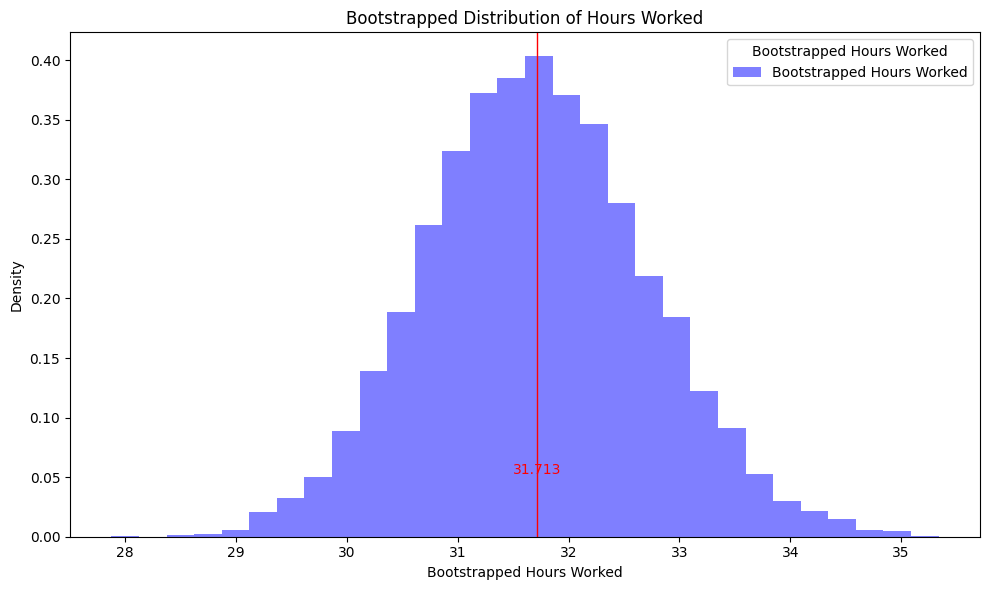

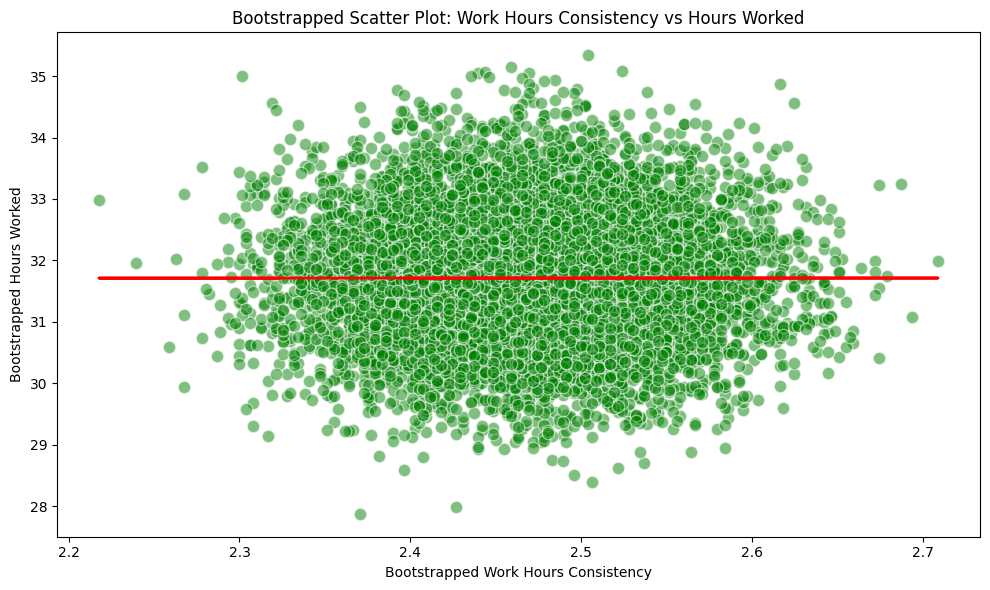

Spearman's correlation between work hours consistency and hours worked: 0.000 (p-value: 0.960)
The null hypothesis is not rejected: no significant correlation between work hours consistency and hours worked.


In [77]:
# Step 2: Bootstrapping and Graphs for Research Question 3

# Function to generate bootstrap samples and compute means
def bootstrap(data, n_iterations=10000, sample_size=None):
    if sample_size is None:
        sample_size = len(data)
    means = []
    for _ in range(n_iterations):
        # Create a bootstrap sample
        sample = resample(data, n_samples=sample_size)
        means.append(np.mean(sample))
    return np.array(means)

# Bootstrap for 'WORK_shift_consistent_hours' and 'WORK_hours_per_week'
bootstrap_consistency = bootstrap(df3_cleaned['WORK_shift_consistent_hours'])
bootstrap_hours_worked = bootstrap(df3_cleaned['WORK_hours_per_week'])

# 1. Null Hypothesis
print("Null Hypothesis (H₀): There is no relationship between work hours consistency and hours worked.")
print("Alternative Hypothesis (H₁): There is a significant relationship between work hours consistency and hours worked.\n")

# 2. Plotting Bootstrapped Histogram for 'WORK_hours_per_week'
plt.figure(figsize=(10, 6))

# Histogram for bootstrapped 'WORK_hours_per_week' values
plt.hist(bootstrap_hours_worked, bins=30, alpha=0.5, label='Bootstrapped Hours Worked', color='blue', density=True)

# Adding a red line for the mean of the bootstrapped samples
mean_value = np.mean(bootstrap_hours_worked)
plt.axvline(mean_value, color='red', linestyle='-', lw=1)  # Thinner red line
plt.text(mean_value, 0.05, f'{mean_value:.3f}', color='red', ha='center', va='bottom')  # Average value label

# Adding title and labels
plt.title("Bootstrapped Distribution of Hours Worked")
plt.xlabel("Bootstrapped Hours Worked")
plt.ylabel("Density")

# Display the plot
plt.legend(title='Bootstrapped Hours Worked')
plt.tight_layout()
plt.show()

# 3. Plotting Bootstrapped Scatter Plot with Line of Best Fit
plt.figure(figsize=(10, 6))

# Scatter plot for bootstrapped values of "WORK_shift_consistent_hours" vs "WORK_hours_per_week"
plt.scatter(bootstrap_consistency, bootstrap_hours_worked, alpha=0.5, color='green', edgecolors='w', s=80)

# Adding a red line for the line of best fit (Linear Regression)
slope, intercept = np.polyfit(bootstrap_consistency, bootstrap_hours_worked, 1)
plt.plot(bootstrap_consistency, slope * bootstrap_consistency + intercept, color='red', lw=2, label='Line of Best Fit')

# Adding title and labels
plt.title("Bootstrapped Scatter Plot: Work Hours Consistency vs Hours Worked")
plt.xlabel("Bootstrapped Work Hours Consistency")
plt.ylabel("Bootstrapped Hours Worked")

# Display the plot
plt.tight_layout()
plt.show()

# 4. Spearman's correlation calculation on bootstrapped samples
corr, p_value = spearmanr(bootstrap_consistency, bootstrap_hours_worked)
print(f"Spearman's correlation between work hours consistency and hours worked: {corr:.3f} (p-value: {p_value:.3f})")

# 5. Hypothesis testing (for correlation)
# Testing the null hypothesis that there is no correlation (rho = 0)
if p_value < 0.05:
    print("The null hypothesis is rejected: there is a significant correlation between work hours consistency and hours worked.")
else:
    print("The null hypothesis is not rejected: no significant correlation between work hours consistency and hours worked.")
